This notebook touches upon: 

* Making a prediction for every pixel
* Working with image segmentation
* Enlarging images with transposed convolutions
* Using bounding boxes for object detection with Faster R-CNN
* Filtering results to reduce false positives

U-Net that has become a de facto design approach for image segmentation.

Image segmentation -> Classification problem, but instead of classifying the whole image, we classify every pixel. So a 200 × 200 image will have 200 × 200 = 40,000 classifications.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import transforms


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm



import os
from imageio import imread
from glob import glob
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import set_seed
from idlmam import train_network, Flatten, View, weight_reset, moveTo

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

torch.backends.cudnn.deterministic=True
set_seed(42)

<ipython-input-2-b32d05908c7c>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [3]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu") 

In [4]:
#This URL has a copy of the dataset, make sure you go to Kaggle though and make an account and follow the license rules. 
data_url_zip = "https://github.com/kamalkraj/DATA-SCIENCE-BOWL-2018/blob/master/data/stage1_train.zip?raw=true"
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import re

#Download this dataset if we have not already done so
if not os.path.isdir('./data/stage1_train'):
    resp = urlopen(data_url_zip)
    os.mkdir("./data/stage1_train")
    zipfile = ZipFile(BytesIO(resp.read()))
    zipfile.extractall(path = './data/stage1_train')
#Grab all the paths to the images we just unziped 
paths = glob("./data/stage1_train/*")

In [6]:
class DSB2018(Dataset):
    """Dataset class for the 2018 Data Science Bowl."""
    def __init__(self, paths):
        """paths: a list of paths to every image folder in the dataset"""
        self.paths = paths
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):   
        #There is only one image in each images path. So we will grab the "first" thing we find with "[0]" at the end
        img_path = glob(self.paths[idx] + "/images/*")[0]        
        #but there are multiple mask images in each mask path
        mask_imgs = glob(self.paths[idx] + "/masks/*")        
        #the image shape is (W, H, 4), the last dimension is an 'alpha' channel that is not used
        img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
        #Now we want this as (3, W, H), which is the normal shape for PyTorch
        img = np.moveaxis(img, -1, 0)
        #Last step for the image, re-scale it to the range [0, 1]
        img = img/255.0
       
        #Every mask image is going to have a shape of (W, H) which has a value of 1 if the pixel is of a nuclei, and a value of 0 if the image is background/ a  _different_ nuclei
        masks = [imread(f)/255.0 for f in mask_imgs]
        
        #Since we want to do simple segmentation, we will create one final mask that contains _all_ nuclei pixels from _every_ mask
        final_mask = np.zeros(masks[0].shape)
        for m in masks:
            final_mask = np.logical_or(final_mask, m)
        final_mask = final_mask.astype(np.float32)
        
        #Not every image in the dataset is the same size.  To simplify the problem, we are going to re-size  every image to be (256, 256)
        img, final_mask = torch.tensor(img), torch.tensor(final_mask).unsqueeze(0) #First we convert to PyTorch tensors
        #The interpolate function can be used to re-size a batch of images. So we make each image a "batch" of 1
        img = F.interpolate(img.unsqueeze(0), (256, 256))
        final_mask = F.interpolate(final_mask.unsqueeze(0), (256, 256))
        #Now the shapes  are (B=1, C, W, H) We need to convert them back to FloatTensors and grab the first item in the "batch". This will return a tuple of: (3, 256, 256), (1, 256, 256)
        return img.type(torch.FloatTensor)[0], final_mask.type(torch.FloatTensor)[0]
#Caption: Class for the 2018 data science bowl dataset.  Each image has a corresponding folder of masks, one for every object in the image. We aren’t going to do that kind of object detection yet. Instead our DataSet class will go through every mask and “or” them together, so that we get a single mask showing every pixel that contains an object. This is done inside __getitem__ which will return a tuple with the input image, followed by the mask we want to predict (i.e., all pixels that contain nuclei). 

<ipython-input-6-711c7e87d554>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
<ipython-input-6-711c7e87d554>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks = [imread(f)/255.0 for f in mask_imgs]


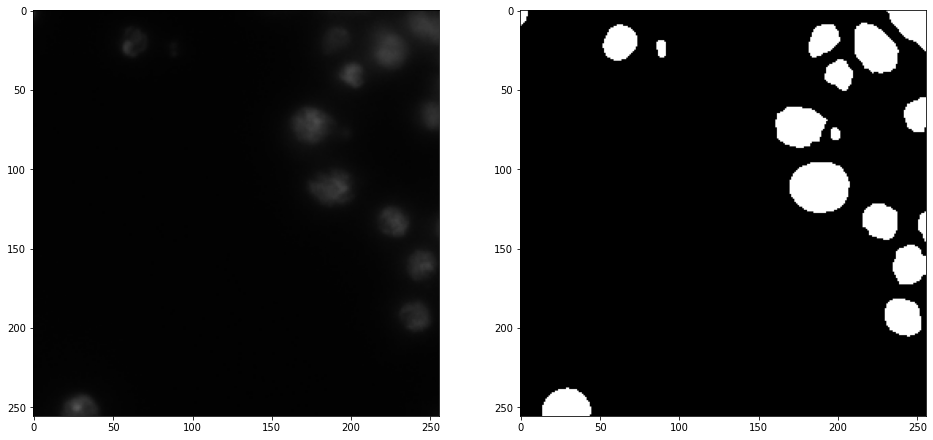

In [7]:
dsb_data = DSB2018(paths)
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)

plt.imshow(dsb_data[0][0].permute(1, 2, 0).numpy())

plt.subplot(1, 2, 2)
plt.imshow(dsb_data[0][1].numpy()[0,:], cmap='gray')

<ipython-input-6-711c7e87d554>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
<ipython-input-6-711c7e87d554>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks = [imread(f)/255.0 for f in mask_imgs]


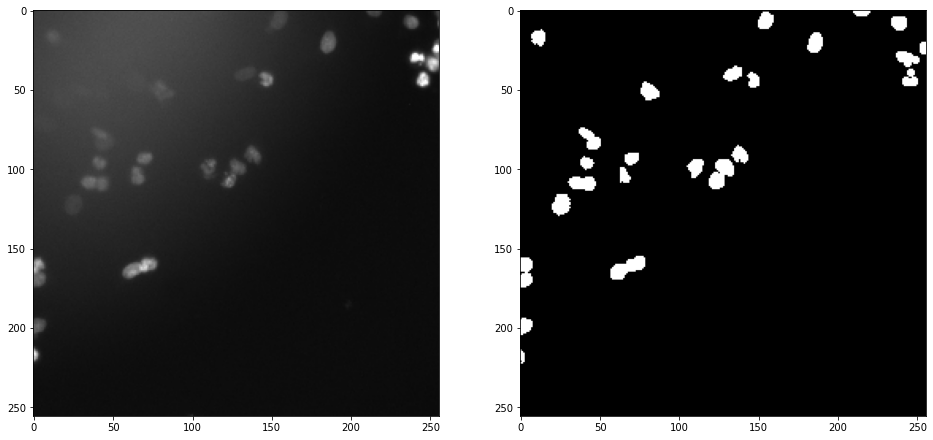

In [8]:
plt.figure(figsize=(16,10))     
plt.subplot(1, 2, 1) 
plt.imshow(dsb_data[1][0].permute(1,2,0).numpy()) 
plt.subplot(1, 2, 2) 
plt.imshow(dsb_data[1][1].numpy()[0,:], cmap='gray')

In [10]:
# Let's create a train test split using batch size of 16 images
train_split, test_split = torch.utils.data.random_split(dsb_data, 
                                                        [500, len(dsb_data)-500])
train_seg_loader = DataLoader(train_split, batch_size=16, shuffle=True)
test_seg_loader = DataLoader(test_split, batch_size=16, shuffle=True)

In [12]:
C = 3 
n_filters = 32 # smallest value of filters we should consider - optuna to pick a better number of filters 
loss_func = nn.BCEWithLogitsLoss() # loss function for segmentation

We want to preserve the image dimensions all throughout our network. We do that with No pooling and padding

In [13]:
def cnnLayer(in_filters, out_filters, kernel_size=3):
    """
    in_filters: how many channels are in the input to this layer 
    out_filters: how many channels should this layer output 
    kernel_size: how large should the filters of this layer be 
    """
    padding = kernel_size//2
    return nn.Sequential(
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
        nn.BatchNorm2d(out_filters),
        nn.LeakyReLU(),
)

segmentation_model = nn.Sequential(
    cnnLayer(C, n_filters),
    * [cnnLayer(n_filters, n_filters) for _ in range(5)], # 5 layers of the same size
    nn.Conv2d(n_filters, 1, (3,3), padding=1),
)

seg_results = train_network(segmentation_model,
                            loss_func,
                            train_seg_loader,
                            epochs=10,
                            device=device,
                            val_loader=test_seg_loader)
    

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

<ipython-input-6-711c7e87d554>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(img_path)[:,:,0:3]#trim off the alpha so we get (W, H, 3)
<ipython-input-6-711c7e87d554>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  masks = [imread(f)/255.0 for f in mask_imgs]


Validating:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Let's plot some results

In [ ]:
index = 6 # Picking a specific example from the dataset that shows a particular result. Change this to look at other entries from the dataset.

with torch.no_grad():#We don't want gradients if we aren't training, so no gradients please!
    #push a test datapoint through the model. Remember the raw outputs are called the logits
    logits = segmentation_model(test_split[index][0].unsqueeze(0).to(device))[0].cpu()
    #apply $\sigma$ to the logits to make predictions and then apply a threshold to get a prediction mask
    pred = torch.sigmoid(logits) >= 0.5

#Plot the input, ground truth, and prediction
plt.figure(figsize=(16,10))
plt.subplot(1, 3, 1)
plt.imshow(test_split[index][0].permute(1,2,0).numpy(), cmap='gray') #First plot the original input to the network
plt.subplot(1, 3, 2)
plt.imshow(test_split[index][1].numpy()[0,:], cmap='gray') #Second is ground truth
plt.subplot(1, 3, 3) 
plt.imshow(pred.numpy()[0,:], cmap='gray') #Third is the prediction our network made

plt.annotate('Error: Hole', color="red", fontsize=20, xy=(130, 230),
            xycoords='data', xytext=(-60, 60),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.5,
                            color = 'red')
            )

plt.annotate('Error: Hole', color="red", fontsize=20, xy=(210, 75),
            xycoords='data', xytext=(-160, -60),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.5,
                            color = 'red')
            )
plt.annotate('Error: Phantom object', color="red", fontsize=20, xy=(247, 15),
            xycoords='data', xytext=(-240, -50),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            linewidth = 2.5,
                            color = 'red')
            )